## **3. Data Analysis : Phases Analysis**
> ####  _Sub-Analytical Question:_
> #### **What are the trends in solar energy adoption across the conflict cycle—pre-conflict, active conflict, and post-conflict periods—in conflict-affected countries?**

After conducting initial data exploration in [EDA 1](https://github.com/MIT-Emerging-Talent/ET6-CDSP-group-08-repo/blob/main/3_data_exploration/IRENA_ONG_explore_1.ipynb) and [EDA 2](https://github.com/MIT-Emerging-Talent/ET6-CDSP-group-08-repo/blob/main/3_data_exploration/IRENA_ONG_explore_2.ipynb), and summarizing key findings in the [Exploration README](https://github.com/MIT-Emerging-Talent/ET6-CDSP-group-08-repo/blob/main/3_data_exploration/README.md), this analysis phase builds on that foundation by focusing on trends across the **three conflict periods** — *pre-conflict*, *active conflict*, and *post-conflict*.

The goal is to investigate whether any **clear patterns emerge** in solar energy adoption among the 9 conflict-affected countries studied.



#### Summary of Previous Discoveries

* **Ukraine dominates the data** with over **8,000 MW by 2024**, nearly **30x** more than any other country.
* **Conflict strongly disrupts growth**: Most countries see capacity drops or stagnation during active conflict periods.
* **Solar growth happens in waves**:

  * Early growth (2004–2010)
  * Mid-phase adopters (2015–2018)
  * Late surge (2018–2022)
* **Growth is possible even in fragile states**: Yemen reached \~250 MW during conflict, Sudan grew steadily to \~100 MW.

> **Key Insight**: *While conflict hinders development, short windows of stability allow for rapid solar expansion. Growth patterns become volatile when conflict resumes.*


#### Focus of This Analysis

This data analysis phase builds on the above insights by examining solar PV growth through the lens of **three conflict phases**—**pre-conflict**, **active conflict**, and **post-conflict**—across **nine countries**:
**Ukraine, Yemen, Sudan, Ethiopia, Libya, Syria, Afghanistan, Iraq, and South Sudan**.

The goal is to:

* Compare how solar development varies by **conflict phase**
* Identify **shared or divergent patterns** across countries
* Explore **exceptions** (e.g., growth during conflict)
* Investigate the **volatility** and **recovery trajectories**


This structured investigation helps answer:
**To what extent does conflict interrupt solar development?**
**Which countries recover faster—and why?**
**Can meaningful infrastructure still be developed during war?**

The following sections use stacked bar charts, heatmaps, and comparative trend lines to dig deeper into this question.


In [ ]:
# 1. Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression


In [1]:
# Visualization settings
%matplotlib inline
sns.set(style="whitegrid", palette="pastel")

In [2]:
# 2. Load Dataset

df = pd.read_excel(
    "../1_datasets/cleaned_data/ONG_conflictcountriesonly.xlsx",
    engine="openpyxl",
)

In [3]:
# 3. Quick Preview
print(df.head())
print("Shape of dataset:", df.shape)

   Region       Sub-region Country ISO3 code         RE or Non-RE  \
0  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
1  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
2  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
3  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
4  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   

  Group Technology   Technology Sub-Technology        Producer Type  Year  \
0     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2000   
1     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2001   
2     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2002   
3     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2003   
4     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2004   

   Electricity Installed Capacity (MW) Conflict Phase  
0                                930.0   pre-conflict  
1         

In [4]:
# 4. Data Quality & Standardization:

# Check for missing values
missing_summary = df.isnull().sum()
print("Missing values per column:\n", missing_summary)

# Optional: See missing data by country
missing_by_country = df[df.isnull().any(axis=1)].groupby("Country").size()
print("Rows with missing data per country:\n", missing_by_country)

# Trim whitespace and convert country names to title case
df["Country"] = df["Country"].str.strip().str.title()

# Ensure 'Year' column is of integer type
df["Year"] = df["Year"].astype(int)


Missing values per column:
 Region                                 0
Sub-region                             0
Country                                0
ISO3 code                              0
RE or Non-RE                           0
Group Technology                       0
Technology                             0
Sub-Technology                         0
Producer Type                          0
Year                                   0
Electricity Installed Capacity (MW)    0
Conflict Phase                         0
dtype: int64
Rows with missing data per country:
 Series([], dtype: int64)


In [5]:
# 5. Sort the dataframe by Country and Year
df = df.sort_values(by=["Country", "Year"]).reset_index(drop=True)
df.head()


,Region,Sub-region,Country,ISO3 code,RE or Non-RE,Group Technology,Technology,Sub-Technology,Producer Type,Year,Electricity Installed Capacity (MW),Conflict Phase
0,Asia,Southern Asia,Afghanistan,AFG,Total Non-Renewable,Fossil fuels,Fossil fuels n.e.s.,Fossil fuels n.e.s.,Off-grid electricity,2000,26.927,pre-conflict
1,Asia,Southern Asia,Afghanistan,AFG,Total Non-Renewable,Fossil fuels,Oil,Oil,On-grid electricity,2000,2.798,pre-conflict
2,Asia,Southern Asia,Afghanistan,AFG,Total Renewable,Hydropower (excl. Pumped Storage),Renewable hydropower,Renewable hydropower,Off-grid electricity,2000,0.003,pre-conflict
3,Asia,Southern Asia,Afghanistan,AFG,Total Renewable,Hydropower (excl. Pumped Storage),Renewable hydropower,Renewable hydropower,On-grid electricity,2000,191.500,pre-conflict
4,Asia,Southern Asia,Afghanistan,AFG,Total Non-Renewable,Fossil fuels,Fossil fuels n.e.s.,Fossil fuels n.e.s.,Off-grid electricity,2001,26.927,active-conflict


In [6]:
# 6. SOLAR ENERGY DATAFRAME
solar_df = df[
    df["RE or Non-RE"].str.contains("Total Renewable", case=False, na=False)
    & df["Group Technology"].str.contains("Solar energy", case=False, na=False)
].copy()

print (solar_df.head())
print(solar_df.isnull().sum())


   Region     Sub-region      Country ISO3 code     RE or Non-RE  \
40   Asia  Southern Asia  Afghanistan       AFG  Total Renewable   
45   Asia  Southern Asia  Afghanistan       AFG  Total Renewable   
50   Asia  Southern Asia  Afghanistan       AFG  Total Renewable   
55   Asia  Southern Asia  Afghanistan       AFG  Total Renewable   
61   Asia  Southern Asia  Afghanistan       AFG  Total Renewable   

   Group Technology          Technology               Sub-Technology  \
40     Solar energy  Solar photovoltaic  Off-grid Solar photovoltaic   
45     Solar energy  Solar photovoltaic  Off-grid Solar photovoltaic   
50     Solar energy  Solar photovoltaic  Off-grid Solar photovoltaic   
55     Solar energy  Solar photovoltaic  Off-grid Solar photovoltaic   
61     Solar energy  Solar photovoltaic  Off-grid Solar photovoltaic   

           Producer Type  Year  Electricity Installed Capacity (MW)  \
40  Off-grid electricity  2009                                0.002   
45  Off-grid ele

In [25]:
#7. Solar Energy Analysis
# Group by Country and Conflict Phase, summing total installed capacity
solar_by_phase = (
    solar_df.groupby(["Country", "Conflict Phase"])[
        "Electricity Installed Capacity (MW)"
    ]
    .sum()
    .reset_index()
)

#  Pivot for cleaner comparison
solar_pivot = solar_by_phase.pivot(
    index="Country",
    columns="Conflict Phase",
    values="Electricity Installed Capacity (MW)",
).fillna(0)

print (solar_pivot)


Conflict Phase              active-conflict  post-conflict  pre-conflict
Country                                                                 
Afghanistan                         292.010        160.428         0.000
Ethiopia                             62.552         42.738        75.132
Iraq                                175.500        273.032         0.000
Libya                                39.341         29.332        15.600
South Sudan                           9.933         53.394         0.000
Sudan (The)                         713.516          0.000         0.009
Syrian Arab Republic (The)          228.493          0.000         0.000
Ukraine                           48770.376          0.000      1310.700
Yemen                              2236.023          0.000         2.369


       Country  Year   Conflict Phase  Electricity Installed Capacity (MW)
0  Afghanistan  2009  active-conflict                                0.002
1  Afghanistan  2010  active-conflict                                0.102
2  Afghanistan  2011  active-conflict                                0.120
3  Afghanistan  2012  active-conflict                               16.122
4  Afghanistan  2013  active-conflict                               16.843
5  Afghanistan  2014  active-conflict                               18.363
6  Afghanistan  2015  active-conflict                               19.011
7  Afghanistan  2016  active-conflict                               20.680
8  Afghanistan  2017  active-conflict                               22.821
9  Afghanistan  2018  active-conflict                               22.596


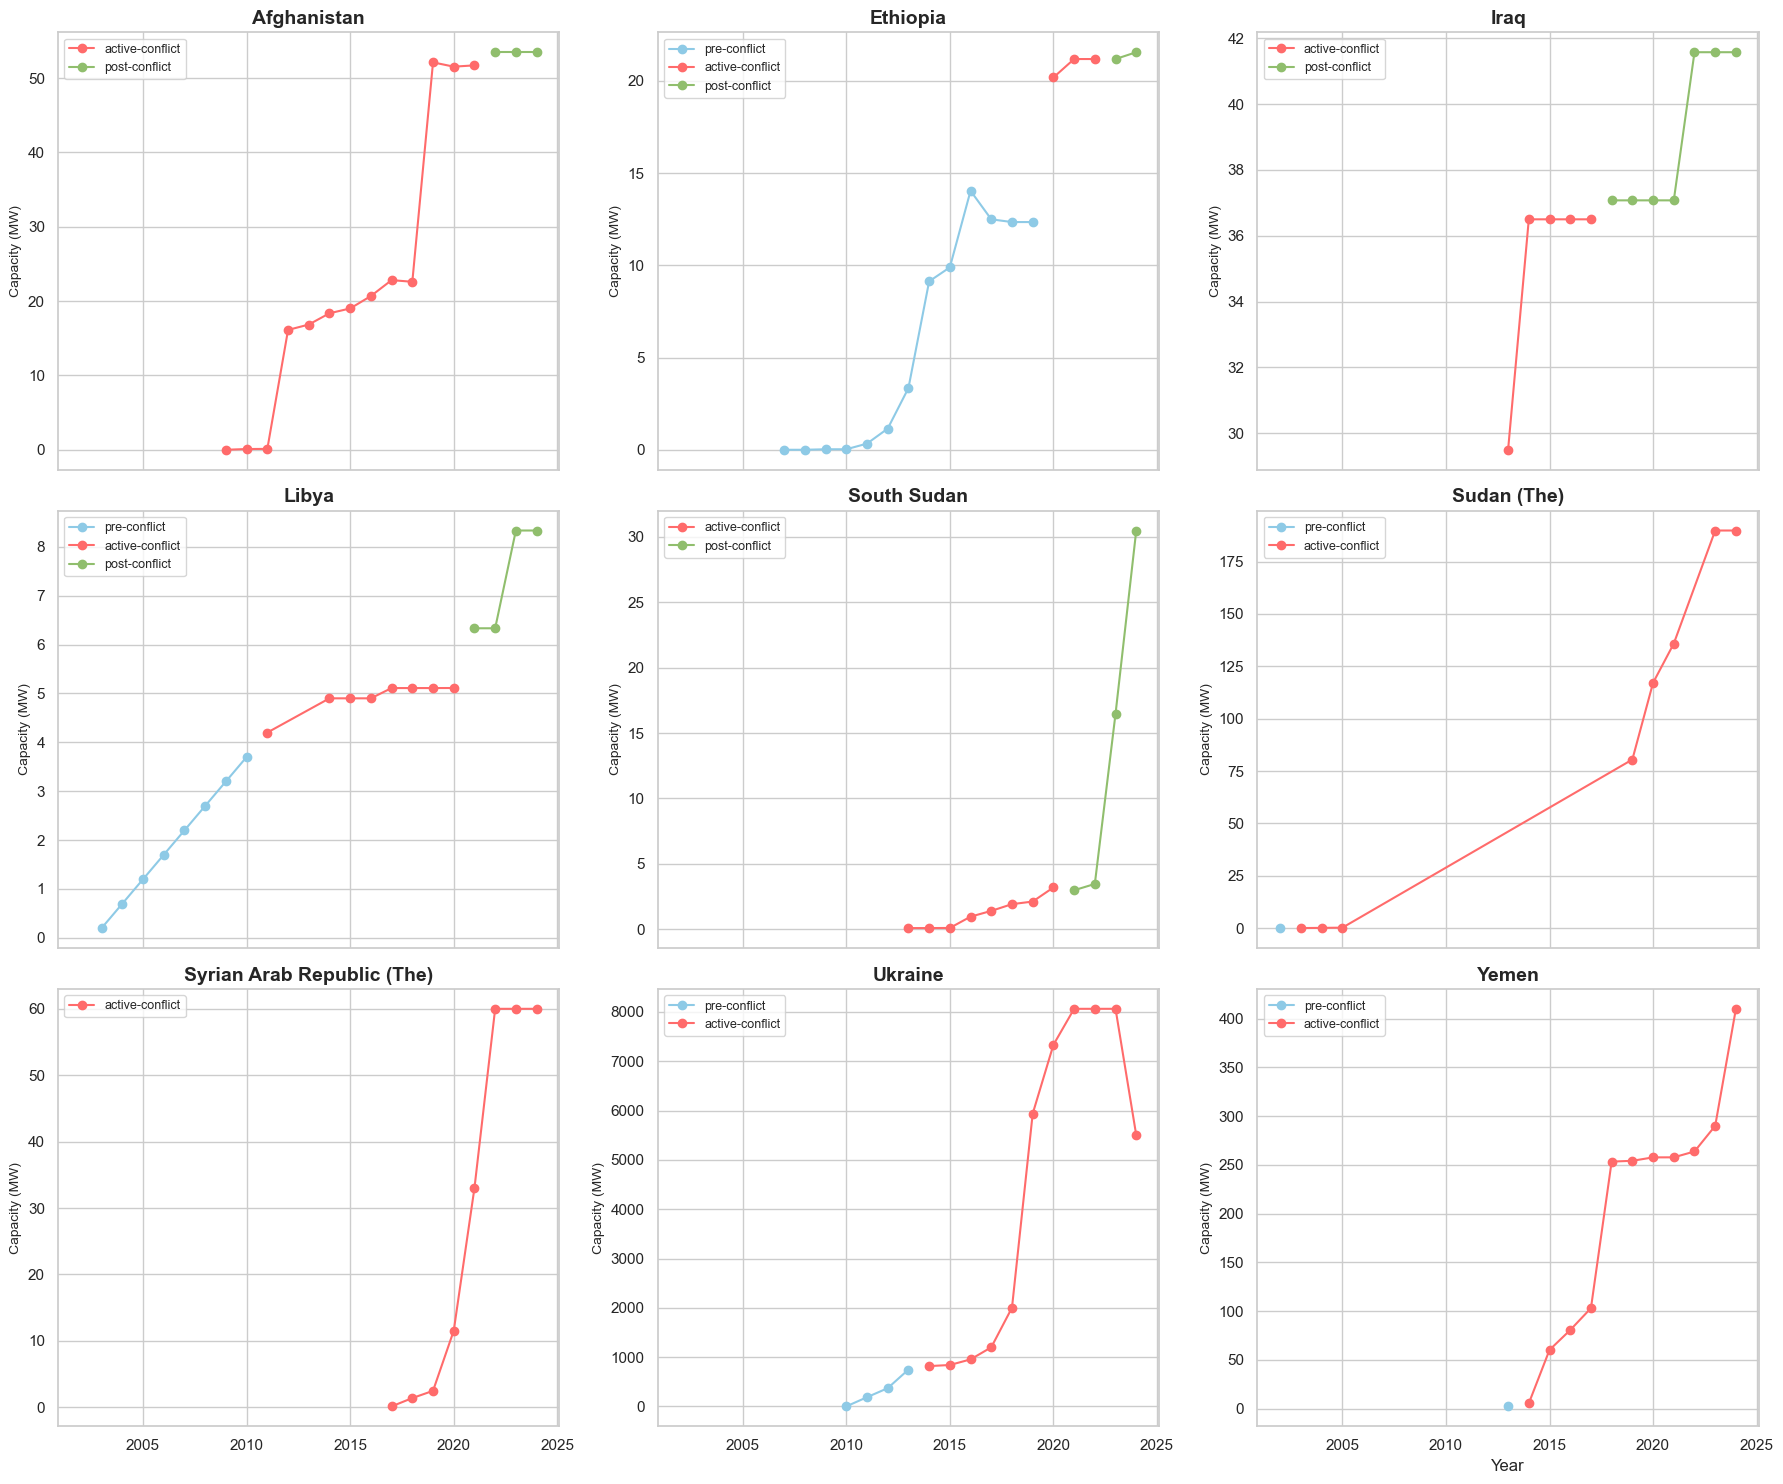

In [31]:
# 7. Solar Energy Analysis by Year
# Group by Country, Year, and Conflict Phase, summing installed capacity
solar_by_phase_year = (
    solar_df.groupby(["Country", "Year", "Conflict Phase"])[
        "Electricity Installed Capacity (MW)"
    ]
    .sum()
    .reset_index()
)

# Optional: sort for readability
solar_by_phase_year.sort_values(["Country", "Year"], inplace=True)

print(solar_by_phase_year.head(10))  # Preview the result

# 8. Visualize Solar Capacity by Conflict Phase

import matplotlib.pyplot as plt

# Custom colors for conflict phases
phase_colors = {
    "pre-conflict": "#8ecae6",
    "active-conflict": "#ff6b6b",
    "post-conflict": "#90be6d",
    "transitional": "#f9c74f",
}

countries = solar_by_phase_year["Country"].unique()
num_countries = len(countries)

# Set up subplots: 3 countries per row
ncols = 3
nrows = (num_countries + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows), sharex=True)
axes = axes.flatten()

for idx, country in enumerate(countries):
    ax = axes[idx]
    subset = solar_by_phase_year[solar_by_phase_year["Country"] == country]

    for phase in subset["Conflict Phase"].unique():
        phase_data = subset[subset["Conflict Phase"] == phase]
        ax.plot(
            phase_data["Year"],
            phase_data["Electricity Installed Capacity (MW)"],
            label=phase,
            color=phase_colors.get(phase, "#999999"),  # default gray if not in dict
            marker="o",
        )

    ax.set_title(f"{country}", fontsize=14, fontweight="bold")
    ax.set_ylabel("Capacity (MW)", fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=9)

# Hide unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.xlabel("Year", fontsize=12)
plt.tight_layout()
plt.show()


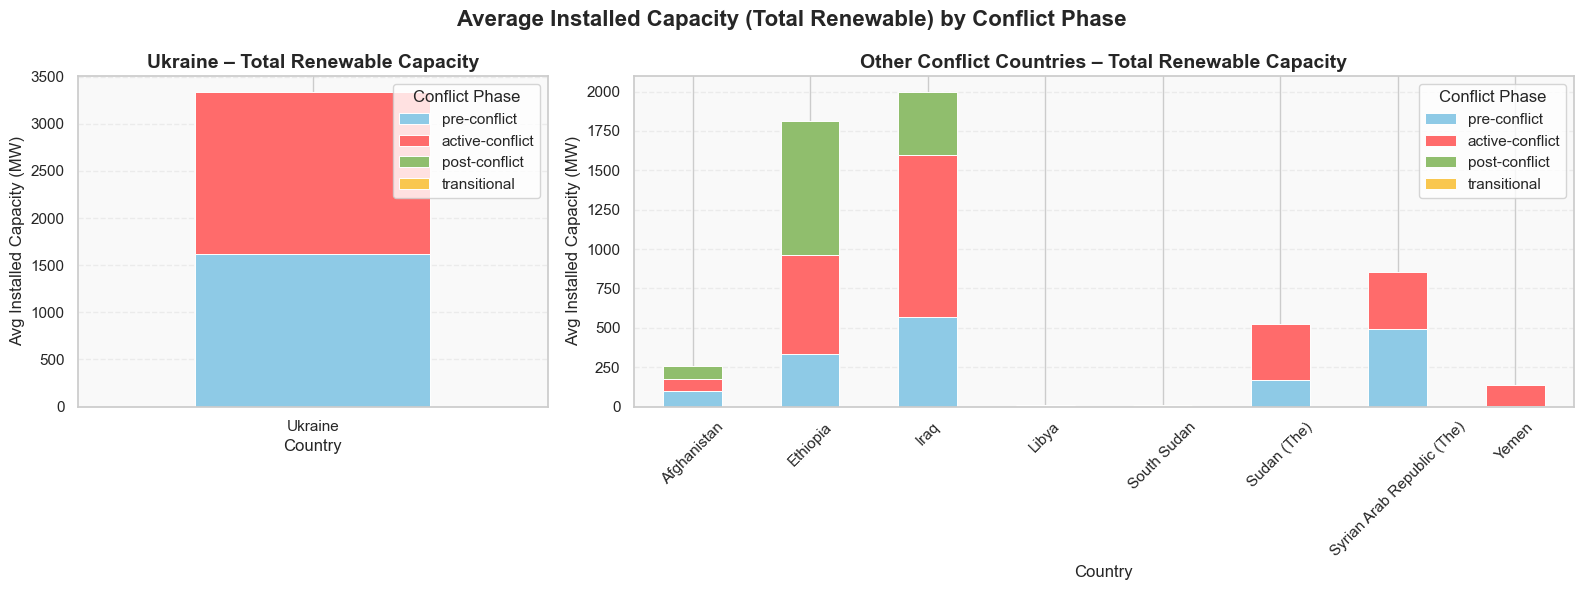

Conflict Phase
active-conflict    577.227956
pre-conflict        51.992963
post-conflict       15.525667
Name: Electricity Installed Capacity (MW), dtype: float64


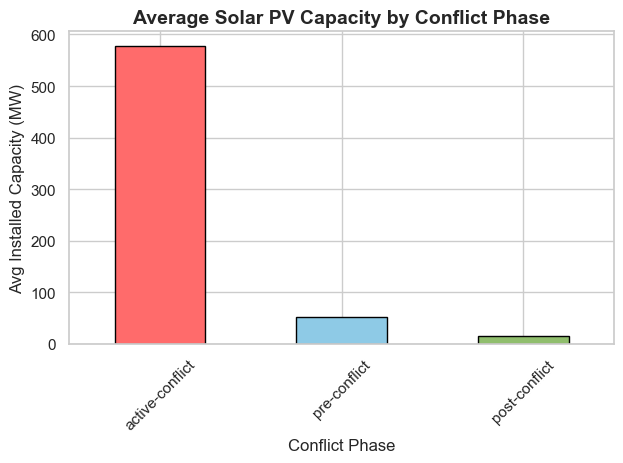

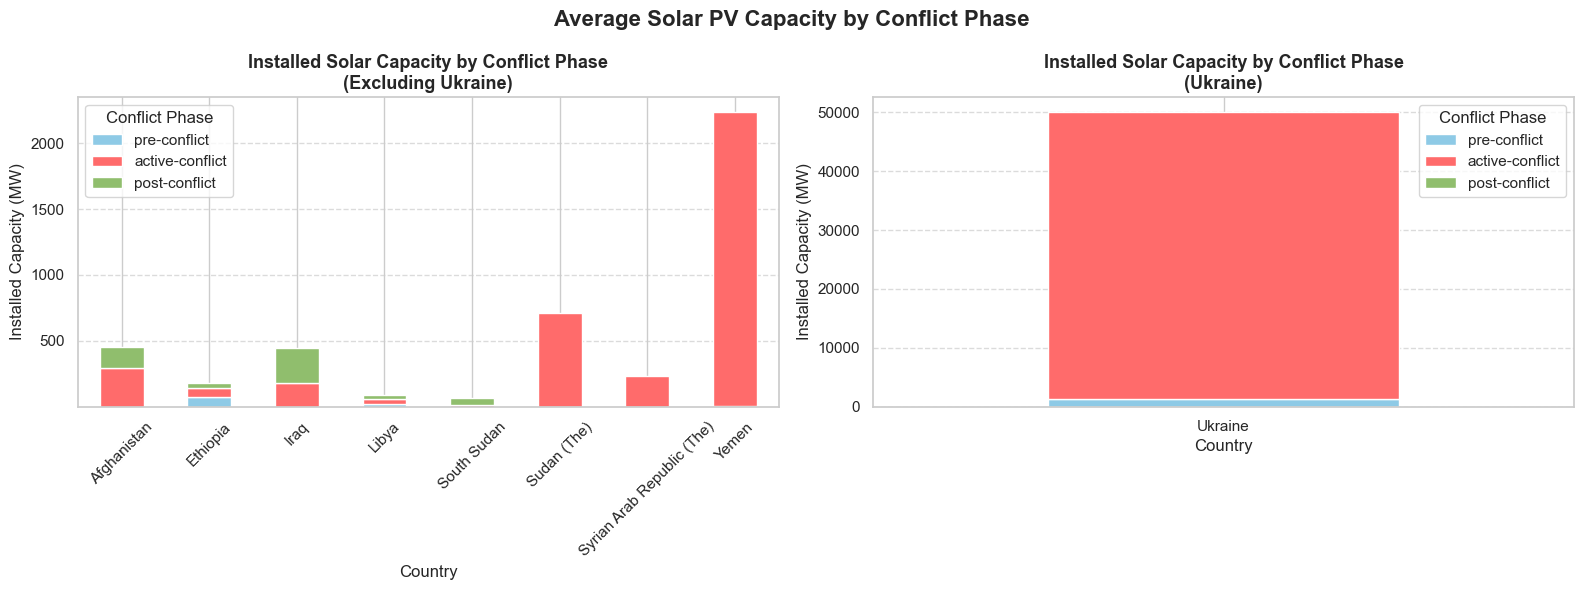

In [ ]:
# 9. Average Installed Capacity (Total Renewable) by Conflict Phase

# === Filter for Total Renewable energy only ===
total_renewable_df = df[df["RE or Non-RE"].str.lower() == "total renewable"]

# === Define consistent conflict phase color palette ===
phase_colors = {
    "pre-conflict": "#8ecae6",
    "active-conflict": "#ff6b6b",
    "post-conflict": "#90be6d",
    "transitional": "#f9c74f",
}

# === Split into Ukraine and Others ===
ukraine_df = total_renewable_df[total_renewable_df["Country"] == "Ukraine"]
others_df = total_renewable_df[total_renewable_df["Country"] != "Ukraine"]


# === Group and pivot ===
def group_and_pivot(df):
    grouped = (
        df.groupby(["Country", "Conflict Phase"])["Electricity Installed Capacity (MW)"]
        .mean()
        .unstack(fill_value=0)
        .reindex(
            columns=[
                "pre-conflict",
                "active-conflict",
                "post-conflict",
                "transitional",
            ],
            fill_value=0,
        )
    )
    return grouped


ukraine_grouped = group_and_pivot(ukraine_df)
others_grouped = group_and_pivot(others_df)

# === Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={"width_ratios": [1, 2]})

# Plot Ukraine
ukraine_grouped.plot(
    kind="bar",
    stacked=True,
    color=[phase_colors[phase] for phase in ukraine_grouped.columns],
    edgecolor="white",
    linewidth=0.7,
    ax=axes[0],
)
axes[0].set_title("Ukraine – Total Renewable Capacity", fontsize=14, weight="bold")
axes[0].set_ylabel("Avg Installed Capacity (MW)")
axes[0].tick_params(axis="x", rotation=0)
axes[0].legend(title="Conflict Phase")
axes[0].grid(axis="y", linestyle="--", alpha=0.3)
axes[0].set_facecolor("#f9f9f9")

# Plot Other Countries
others_grouped.plot(
    kind="bar",
    stacked=True,
    color=[phase_colors[phase] for phase in others_grouped.columns],
    edgecolor="white",
    linewidth=0.7,
    ax=axes[1],
)
axes[1].set_title(
    "Other Conflict Countries – Total Renewable Capacity", fontsize=14, weight="bold"
)
axes[1].set_ylabel("Avg Installed Capacity (MW)")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(title="Conflict Phase")
axes[1].grid(axis="y", linestyle="--", alpha=0.3)
axes[1].set_facecolor("#f9f9f9")

fig.suptitle(
    "Average Installed Capacity (Total Renewable) by Conflict Phase",
    fontsize=16,
    weight="bold",
)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 10. Average Solar Energy Capacity by Conflict Phase

avg_capacity_by_phase = (
    solar_df.groupby("Conflict Phase")["Electricity Installed Capacity (MW)"]
    .mean()
    .sort_values(ascending=False)
)

print(avg_capacity_by_phase)

# Plot
avg_capacity_by_phase.plot(
    kind="bar",
    color=[phase_colors[phase] for phase in avg_capacity_by_phase.index],
    edgecolor="black",
)

plt.title("Average Solar PV Capacity by Conflict Phase", fontsize=14, weight="bold")
plt.ylabel("Avg Installed Capacity (MW)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 11. Visualizing Solar Capacity by Conflict Phase

# Ensure consistent column order
ordered_phases = ["pre-conflict", "active-conflict", "post-conflict", "transitional"]
existing_phases = [phase for phase in ordered_phases if phase in solar_pivot.columns]
solar_pivot = solar_pivot[existing_phases]

# Split the data
ukraine_only = solar_pivot.loc[solar_pivot.index == "Ukraine"]
others_only = solar_pivot.loc[solar_pivot.index != "Ukraine"]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Chart 1: Other countries
others_only.plot(
    kind="bar",
    stacked=True,
    ax=axes[0],
    color=[phase_colors[phase] for phase in others_only.columns],
)
axes[0].set_title(
    "Installed Solar Capacity by Conflict Phase\n(Excluding Ukraine)",
    fontsize=13,
    weight="bold",
)
axes[0].set_ylabel("Installed Capacity (MW)")
axes[0].set_xlabel("Country")
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend(title="Conflict Phase")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Chart 2: Ukraine only
ukraine_only.plot(
    kind="bar",
    stacked=True,
    ax=axes[1],
    color=[phase_colors[phase] for phase in ukraine_only.columns],
)
axes[1].set_title(
    "Installed Solar Capacity by Conflict Phase\n(Ukraine)", fontsize=13, weight="bold"
)
axes[1].set_ylabel("Installed Capacity (MW)")
axes[1].set_xlabel("Country")
axes[1].tick_params(axis="x", rotation=0)
axes[1].legend(title="Conflict Phase")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Overall layout
fig.suptitle("Average Solar PV Capacity by Conflict Phase", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()


Solar Capacity Impact Analysis by Conflict Phase (Excluding Ukraine)
Analyzing 6 countries with solar data

SUMMARY TABLE: Solar Capacity Impact by Conflict Phase
Country                   Pre-Conflict Conflict     Post-Conflict Trend       
---------------------------------------------------------------------------
Iraq                      0.0          11.7         39.0          Recovery    
Afghanistan               0.0          13.9         53.5          Recovery    
Libya                     1.4          4.9          7.3           Increased   
Yemen                     0.2          203.3        0.0           Increased   
Ethiopia                  3.8          20.9         21.4          Increased   
South Sudan               0.0          1.2          13.3          Recovery    

ANALYSIS BY TREND CATEGORY

RECOVERY (3 countries):
  • Iraq: 0.0 → 11.7 → 39.0 MW
  • Afghanistan: 0.0 → 13.9 → 53.5 MW
  • South Sudan: 0.0 → 1.2 → 13.3 MW

INCREASED (3 countries):
  • Libya: 1.4 → 4.9 → 

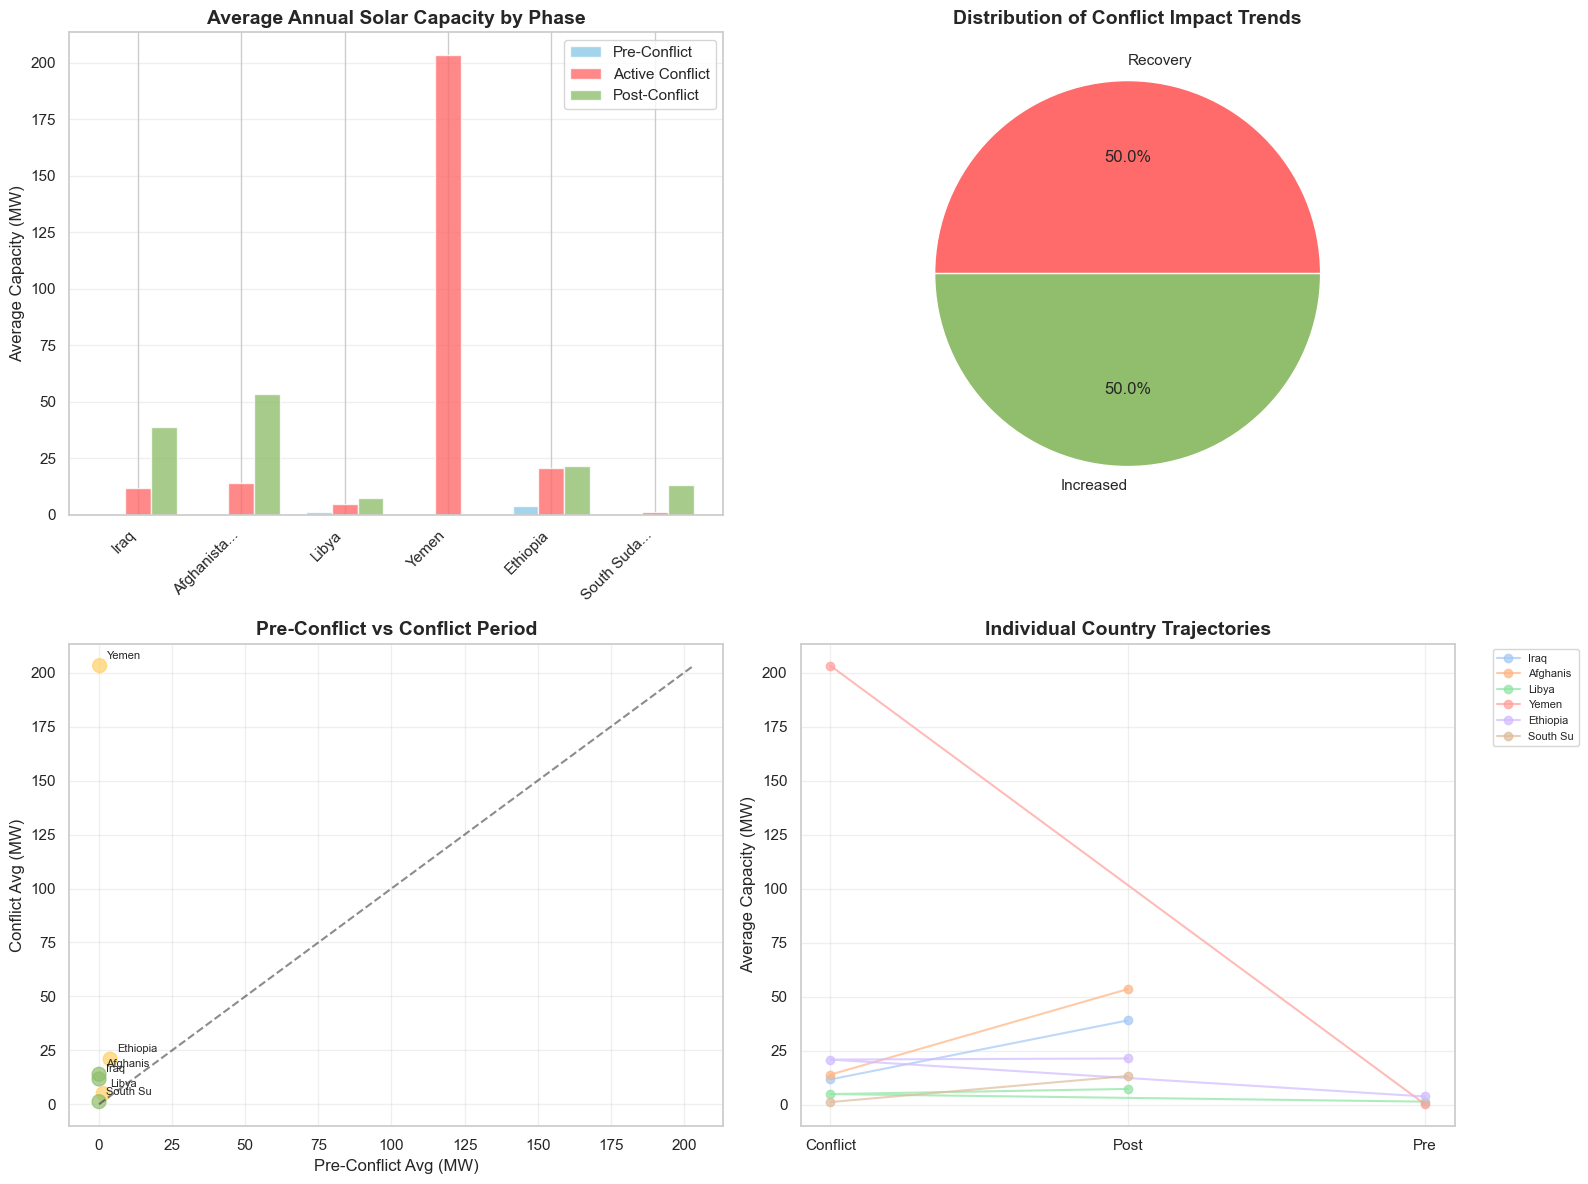


SEPARATE ANALYSIS: UKRAINE
Ukraine Solar Capacity Analysis:
  Pre-Conflict (2000-2013): 93.6 MW average annually
  Active Conflict (2014-2024): 4433.7 MW average annually
  Change during conflict: +4635.7%
  Trend: INCREASED - Remarkable growth despite ongoing conflict


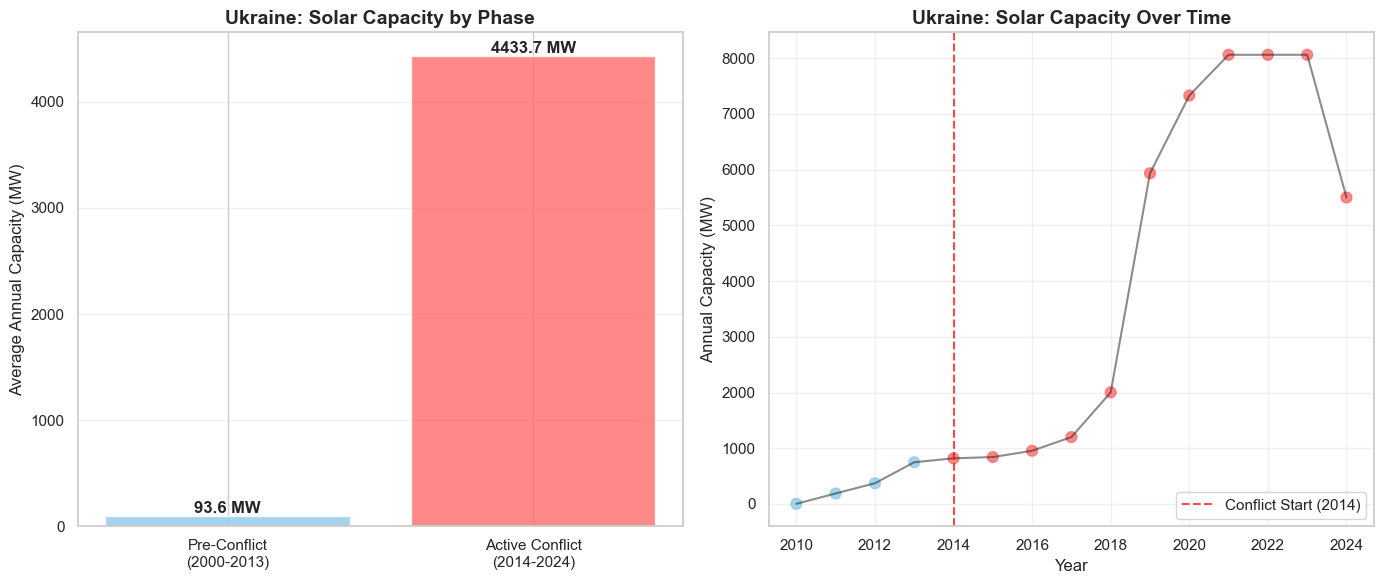


Ukraine Context:
  • Ukraine represents a unique case of ongoing conflict (2014-present)
  • Unlike other countries, Ukraine has no post-conflict period yet
  • This makes it distinct from countries with complete conflict cycles

Summary DataFrame shape: (6, 5)
Use 'summary_df' variable for further analysis


In [ ]:
# 12. Solar Capacity Impact Analysis by Conflict Phase

# Your conflict phase definitions
conflict_phases = {
    "Iraq": {
        "pre-conflict": range(2000, 2003),
        "active-conflict": range(2003, 2018),
        "post-conflict": range(2018, 2025),
    },
    "Afghanistan": {
        "pre-conflict": range(2000, 2001),
        "active-conflict": range(2001, 2022),
        "post-conflict": range(2022, 2025),
    },
    "Libya": {
        "pre-conflict": range(2000, 2011),
        "active-conflict": [2011] + list(range(2014, 2021)),
        "transitional": range(2012, 2014),
        "post-conflict": range(2021, 2025),
    },
    "Yemen": {
        "pre-conflict": range(2000, 2014),
        "active-conflict": range(2014, 2025),
    },
    "Ukraine": {
        "pre-conflict": range(2000, 2014),
        "active-conflict": range(2014, 2025),
    },
    "Ethiopia": {
        "pre-conflict": range(2000, 2020),
        "active-conflict": range(2020, 2023),
        "post-conflict": range(2023, 2025),
    },
    "South Sudan": {
        "pre-conflict": range(2000, 2012),
        "active-conflict": range(2013, 2021),
        "post-conflict": range(2021, 2025),
        "transitional": [2012],
    },
    "Sudan (the)": {
        "pre-conflict": range(2000, 2003),
        "active-conflict": list(range(2003, 2006))
        + list(range(2019, 2022))
        + list(range(2023, 2025)),
        "transitional": list(range(2006, 2019)) + [2022],
    },
    "Syrian Arab Republic (the)": {
        "pre-conflict": range(2000, 2011),
        "active-conflict": range(2011, 2025),
    },
}

# Filter to only solar type if needed
if "Type" in solar_df.columns:
    solar_df = solar_df[solar_df["Type"].str.lower() == "solar"].copy()

# Ensure required columns exist
required_columns = ["Country", "Year", "Electricity Installed Capacity (MW)"]
missing_columns = [col for col in required_columns if col not in solar_df.columns]
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")


# Calculate average capacity per year for each country and phase
def calculate_phase_averages(country_data, country_name):
    """Calculate average annual capacity for each phase of a country"""
    if country_name not in conflict_phases:
        return {}

    phases = conflict_phases[country_name]
    averages = {}

    for phase, years in phases.items():
        if isinstance(years, range):
            year_list = list(years)
        else:
            year_list = list(years)

        # Get data for this phase
        phase_data = country_data[country_data["Year"].isin(year_list)]

        if len(phase_data) > 0 and len(year_list) > 0:
            # Calculate average annual capacity
            total_capacity = phase_data["Electricity Installed Capacity (MW)"].sum()
            num_years = len(year_list)
            averages[phase] = total_capacity / num_years
        else:
            averages[phase] = 0.0

    return averages


# Get available countries (exclude Ukraine from main analysis)
conflict_countries = list(conflict_phases.keys())
available_countries = [
    c
    for c in conflict_countries
    if c in solar_df["Country"].unique() and c != "Ukraine"
]

print("Solar Capacity Impact Analysis by Conflict Phase (Excluding Ukraine)")
print("=" * 70)
print(f"Analyzing {len(available_countries)} countries with solar data")
print()

# Create summary table data
summary_data = []

for country in available_countries:
    country_data = solar_df[solar_df["Country"] == country].copy()

    if len(country_data) > 0:
        averages = calculate_phase_averages(country_data, country)

        # Get the three main phases
        pre_avg = averages.get("pre-conflict", 0)
        active_avg = averages.get("active-conflict", 0)
        post_avg = averages.get("post-conflict", 0)

        # Determine trend with better logic
        trend = "No Data"

        if pre_avg > 0 and active_avg > 0:
            if post_avg > 0:
                # All three phases available
                pre_to_active_change = (
                    (active_avg - pre_avg) / pre_avg if pre_avg > 0 else 0
                )
                active_to_post_change = (
                    (post_avg - active_avg) / active_avg if active_avg > 0 else 0
                )

                if pre_to_active_change < -0.3:  # 30% drop threshold
                    if active_to_post_change > 0.3:  # 30% recovery threshold
                        trend = "Recovery"
                    else:
                        trend = "Drop"
                elif pre_to_active_change > 0.3:  # 30% increase threshold
                    trend = "Increased"
                else:
                    trend = "Stable"
            else:
                # Only pre and active available
                change = (active_avg - pre_avg) / pre_avg if pre_avg > 0 else 0
                if change < -0.3:
                    trend = "Drop"
                elif change > 0.3:
                    trend = "Increased"
                else:
                    trend = "Stable"
        elif active_avg > 0 and post_avg > 0:
            # Only active and post available
            change = (post_avg - active_avg) / active_avg if active_avg > 0 else 0
            if change > 0.3:
                trend = "Recovery"
            elif change < -0.3:
                trend = "Collapse"
            else:
                trend = "Stable"

        summary_data.append(
            {
                "Country": country,
                "Pre-Conflict Avg (MW)": round(pre_avg, 1),
                "Conflict Avg (MW)": round(active_avg, 1),
                "Post-Conflict Avg (MW)": round(post_avg, 1),
                "Trend": trend,
            }
        )

# Create DataFrame for summary table
summary_df = pd.DataFrame(summary_data)

# Display the summary table
if not summary_df.empty:
    print("SUMMARY TABLE: Solar Capacity Impact by Conflict Phase")
    print("=" * 75)
    print(
        f"{'Country':<25} {'Pre-Conflict':<12} {'Conflict':<12} {'Post-Conflict':<13} {'Trend':<12}"
    )
    print("-" * 75)

    for _, row in summary_df.iterrows():
        country_short = row["Country"][:24]  # Truncate long names
        print(
            f"{country_short:<25} {row['Pre-Conflict Avg (MW)']:<12.1f} "
            f"{row['Conflict Avg (MW)']:<12.1f} {row['Post-Conflict Avg (MW)']:<13.1f} "
            f"{row['Trend']:<12}"
        )

    print()

    # Categorize countries by trend
    trend_categories = {
        "Drop": [],
        "Recovery": [],
        "Increased": [],
        "Stable": [],
        "Collapse": [],
    }

    for _, row in summary_df.iterrows():
        trend = row["Trend"]
        if trend in trend_categories:
            trend_categories[trend].append(row["Country"])

    print("ANALYSIS BY TREND CATEGORY")
    print("=" * 40)
    for trend, countries in trend_categories.items():
        if countries:
            print(f"\n{trend.upper()} ({len(countries)} countries):")
            for country in countries:
                row = summary_df[summary_df["Country"] == country].iloc[0]
                print(
                    f"  • {country}: {row['Pre-Conflict Avg (MW)']:.1f} → "
                    f"{row['Conflict Avg (MW)']:.1f} → {row['Post-Conflict Avg (MW)']:.1f} MW"
                )

    # Create visualization only if we have data
    if len(summary_df) > 0:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1: Bar chart comparing averages
        countries_to_plot = summary_df["Country"].tolist()
        pre_values = summary_df["Pre-Conflict Avg (MW)"].tolist()
        conflict_values = summary_df["Conflict Avg (MW)"].tolist()
        post_values = summary_df["Post-Conflict Avg (MW)"].tolist()

        x = np.arange(len(countries_to_plot))
        width = 0.25

        ax1.bar(
            x - width,
            pre_values,
            width,
            label="Pre-Conflict",
            color="#8ecae6",
            alpha=0.8,
        )
        ax1.bar(
            x,
            conflict_values,
            width,
            label="Active Conflict",
            color="#ff6b6b",
            alpha=0.8,
        )
        ax1.bar(
            x + width,
            post_values,
            width,
            label="Post-Conflict",
            color="#90be6d",
            alpha=0.8,
        )

        ax1.set_title(
            "Average Annual Solar Capacity by Phase", fontsize=14, fontweight="bold"
        )
        ax1.set_ylabel("Average Capacity (MW)")
        ax1.set_xticks(x)
        ax1.set_xticklabels(
            [c[:10] + "..." if len(c) > 10 else c for c in countries_to_plot],
            rotation=45,
            ha="right",
        )
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis="y")

        # Plot 2: Trend distribution
        trend_counts = summary_df["Trend"].value_counts()
        colors = ["#ff6b6b", "#90be6d", "#ffd166", "#8ecae6", "#ff8fab"]

        if not trend_counts.empty:
            ax2.pie(
                trend_counts.values,
                labels=trend_counts.index,
                autopct="%1.1f%%",
                colors=colors[: len(trend_counts)],
            )
            ax2.set_title(
                "Distribution of Conflict Impact Trends", fontsize=14, fontweight="bold"
            )

        # Plot 3: Scatter plot - Pre vs Conflict
        if len(pre_values) > 0 and len(conflict_values) > 0:
            scatter_colors = []
            for t in summary_df["Trend"]:
                if t == "Drop":
                    scatter_colors.append("#ff6b6b")
                elif t == "Recovery":
                    scatter_colors.append("#90be6d")
                elif t == "Increased":
                    scatter_colors.append("#ffd166")
                else:
                    scatter_colors.append("#8ecae6")

            ax3.scatter(pre_values, conflict_values, c=scatter_colors, alpha=0.7, s=100)

            max_val = max(
                max(pre_values) if pre_values else [0],
                max(conflict_values) if conflict_values else [0],
            )
            if max_val > 0:
                ax3.plot(
                    [0, max_val], [0, max_val], "k--", alpha=0.5, label="No Change Line"
                )

            ax3.set_xlabel("Pre-Conflict Avg (MW)")
            ax3.set_ylabel("Conflict Avg (MW)")
            ax3.set_title(
                "Pre-Conflict vs Conflict Period", fontsize=14, fontweight="bold"
            )
            ax3.grid(True, alpha=0.3)

            # Add country labels to scatter plot
            for i, country in enumerate(countries_to_plot):
                if i < len(pre_values) and i < len(conflict_values):
                    ax3.annotate(
                        country[:8],
                        (pre_values[i], conflict_values[i]),
                        xytext=(5, 5),
                        textcoords="offset points",
                        fontsize=8,
                    )

        # Plot 4: Change patterns
        for i, country in enumerate(countries_to_plot):
            phases = ["Pre", "Conflict", "Post"]
            values = [pre_values[i], conflict_values[i], post_values[i]]

            # Only plot if we have data
            valid_indices = [j for j, v in enumerate(values) if v > 0]
            if len(valid_indices) > 1:
                valid_phases = [phases[j] for j in valid_indices]
                valid_values = [values[j] for j in valid_indices]
                ax4.plot(valid_phases, valid_values, "o-", alpha=0.7, label=country[:8])

        ax4.set_title("Individual Country Trajectories", fontsize=14, fontweight="bold")
        ax4.set_ylabel("Average Capacity (MW)")
        ax4.grid(True, alpha=0.3)
        ax4.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

        plt.tight_layout()
        plt.show()

else:
    print("No data available for analysis.")

# Separate analysis for Ukraine
print("\n" + "=" * 70)
print("SEPARATE ANALYSIS: UKRAINE")
print("=" * 70)

ukraine_data = solar_df[solar_df["Country"] == "Ukraine"].copy()
if len(ukraine_data) > 0:
    ukraine_averages = calculate_phase_averages(ukraine_data, "Ukraine")

    ukraine_pre = ukraine_averages.get("pre-conflict", 0)
    ukraine_active = ukraine_averages.get("active-conflict", 0)

    # Ukraine only has pre-conflict and active-conflict phases
    print(f"Ukraine Solar Capacity Analysis:")
    print(f"  Pre-Conflict (2000-2013): {ukraine_pre:.1f} MW average annually")
    print(f"  Active Conflict (2014-2024): {ukraine_active:.1f} MW average annually")

    if ukraine_pre > 0 and ukraine_active > 0:
        change_pct = ((ukraine_active - ukraine_pre) / ukraine_pre) * 100
        print(f"  Change during conflict: {change_pct:+.1f}%")

        if change_pct > 30:
            ukraine_trend = "INCREASED - Remarkable growth despite ongoing conflict"
        elif change_pct < -30:
            ukraine_trend = "DROPPED - Significant decline during conflict"
        else:
            ukraine_trend = "STABLE - Minimal change during conflict"
    else:
        ukraine_trend = "INSUFFICIENT DATA"

    print(f"  Trend: {ukraine_trend}")

    # Create Ukraine-specific visualization
    if ukraine_pre > 0 or ukraine_active > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Bar chart for Ukraine
        phases = ["Pre-Conflict\n(2000-2013)", "Active Conflict\n(2014-2024)"]
        values = [ukraine_pre, ukraine_active]
        colors = ["#8ecae6", "#ff6b6b"]

        bars = ax1.bar(phases, values, color=colors, alpha=0.8)
        ax1.set_title(
            "Ukraine: Solar Capacity by Phase", fontsize=14, fontweight="bold"
        )
        ax1.set_ylabel("Average Annual Capacity (MW)")
        ax1.grid(True, alpha=0.3, axis="y")

        # Add value labels
        for bar, val in zip(bars, values):
            if val > 0:
                ax1.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height(),
                    f"{val:.1f} MW",
                    ha="center",
                    va="bottom",
                    fontweight="bold",
                )

        # Time series plot for Ukraine
        ukraine_yearly = ukraine_data.groupby("Year")[
            "Electricity Installed Capacity (MW)"
        ].sum()

        if not ukraine_yearly.empty:
            years = ukraine_yearly.index
            capacities = ukraine_yearly.values

            # Color points by phase
            colors_by_year = []
            for year in years:
                if year in conflict_phases["Ukraine"]["pre-conflict"]:
                    colors_by_year.append("#8ecae6")
                elif year in conflict_phases["Ukraine"]["active-conflict"]:
                    colors_by_year.append("#ff6b6b")
                else:
                    colors_by_year.append("gray")

            ax2.scatter(years, capacities, c=colors_by_year, s=60, alpha=0.8)
            ax2.plot(years, capacities, "k-", alpha=0.5)

            # Add vertical line at conflict start
            ax2.axvline(
                x=2014,
                color="red",
                linestyle="--",
                alpha=0.7,
                label="Conflict Start (2014)",
            )

            ax2.set_title(
                "Ukraine: Solar Capacity Over Time", fontsize=14, fontweight="bold"
            )
            ax2.set_xlabel("Year")
            ax2.set_ylabel("Annual Capacity (MW)")
            ax2.grid(True, alpha=0.3)
            ax2.legend()

        plt.tight_layout()
        plt.show()

    print(f"\nUkraine Context:")
    print(f"  • Ukraine represents a unique case of ongoing conflict (2014-present)")
    print(f"  • Unlike other countries, Ukraine has no post-conflict period yet")
    print(f"  • This makes it distinct from countries with complete conflict cycles")

else:
    print("No Ukraine solar data found in the dataset")

# Export summary table as DataFrame for further analysis
if "summary_df" in locals():
    print(f"\nSummary DataFrame shape: {summary_df.shape}")
    print("Use 'summary_df' variable for further analysis")
else:
    print("\nNo summary data generated - check your input data")


Regression Coefficient: 1359.32
Intercept: 568.99
✅ Conflict periods show a positive effect on growth in solar capacity.


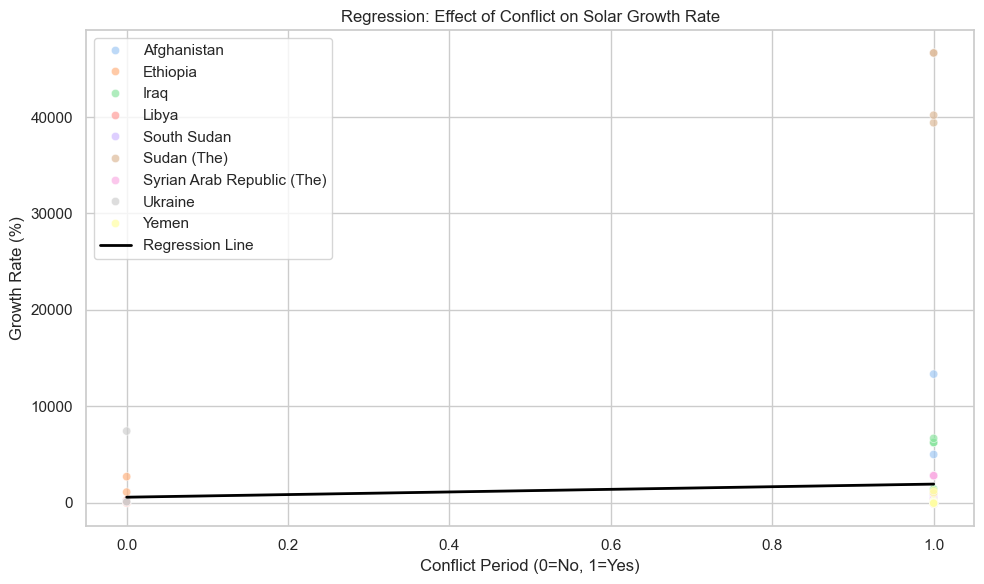

In [36]:
# 13. Simple Regression Analysis on Solar Growth Rate During Conflict Periods

# 1. Filter only solar energy from Total Renewable
solar_df = df[
    df["RE or Non-RE"].str.contains("Total Renewable", case=False, na=False)
    & df["Group Technology"].str.contains("Solar energy", case=False, na=False)
].copy()

# 2. Make sure relevant columns are numeric
solar_df["Electricity Installed Capacity (MW)"] = pd.to_numeric(
    solar_df["Electricity Installed Capacity (MW)"], errors="coerce"
)

# 3. Sort to calculate year-on-year growth per country
solar_df = solar_df.sort_values(by=["Country", "Year"])

# 4. Compute growth rate (% change from previous year)
solar_df["Growth Rate (%)"] = (
    solar_df.groupby("Country")["Electricity Installed Capacity (MW)"].pct_change()
    * 100
)

# 5. Drop missing values in Growth Rate
solar_df = solar_df.dropna(subset=["Growth Rate (%)"])

# 6. Define active + post conflict as conflict period
solar_df["Conflict"] = solar_df["Conflict Phase"].apply(
    lambda x: 1 if str(x).lower() in ["active-conflict", "post-conflict"] else 0
)

# 7. Simple Regression: Does being in a conflict period affect growth rate?
X = solar_df[["Conflict"]]
y = solar_df["Growth Rate (%)"]

model = LinearRegression()
model.fit(X, y)
solar_df["Predicted Growth"] = model.predict(X)

# 8. Print regression coefficient and interpretation
coef = model.coef_[0]
intercept = model.intercept_

print("Regression Coefficient:", round(coef, 2))
print("Intercept:", round(intercept, 2))

if coef < 0:
    print(
        "⚠️ During conflict periods (active+post), growth in solar capacity decreases on average."
    )
elif coef > 0:
    print("✅ Conflict periods show a positive effect on growth in solar capacity.")
else:
    print("➖ Conflict periods show no measurable effect on solar growth rate.")

# 9. Optional: Plot actual vs predicted growth (for interpretation)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=solar_df, x="Conflict", y="Growth Rate (%)", hue="Country", alpha=0.7
)
sns.lineplot(
    data=solar_df,
    x="Conflict",
    y="Predicted Growth",
    color="black",
    linewidth=2,
    label="Regression Line",
)
plt.title("Regression: Effect of Conflict on Solar Growth Rate")
plt.xlabel("Conflict Period (0=No, 1=Yes)")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


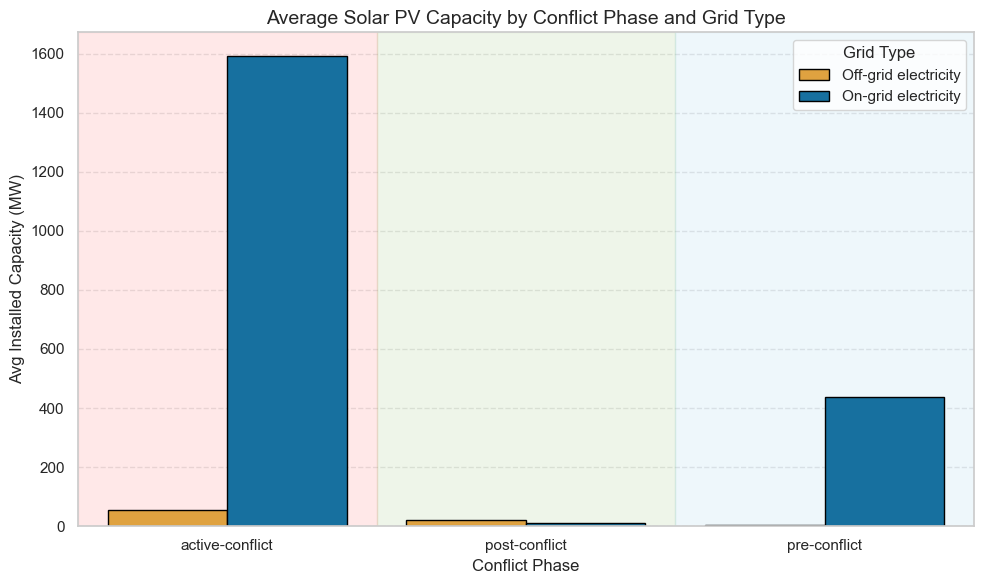

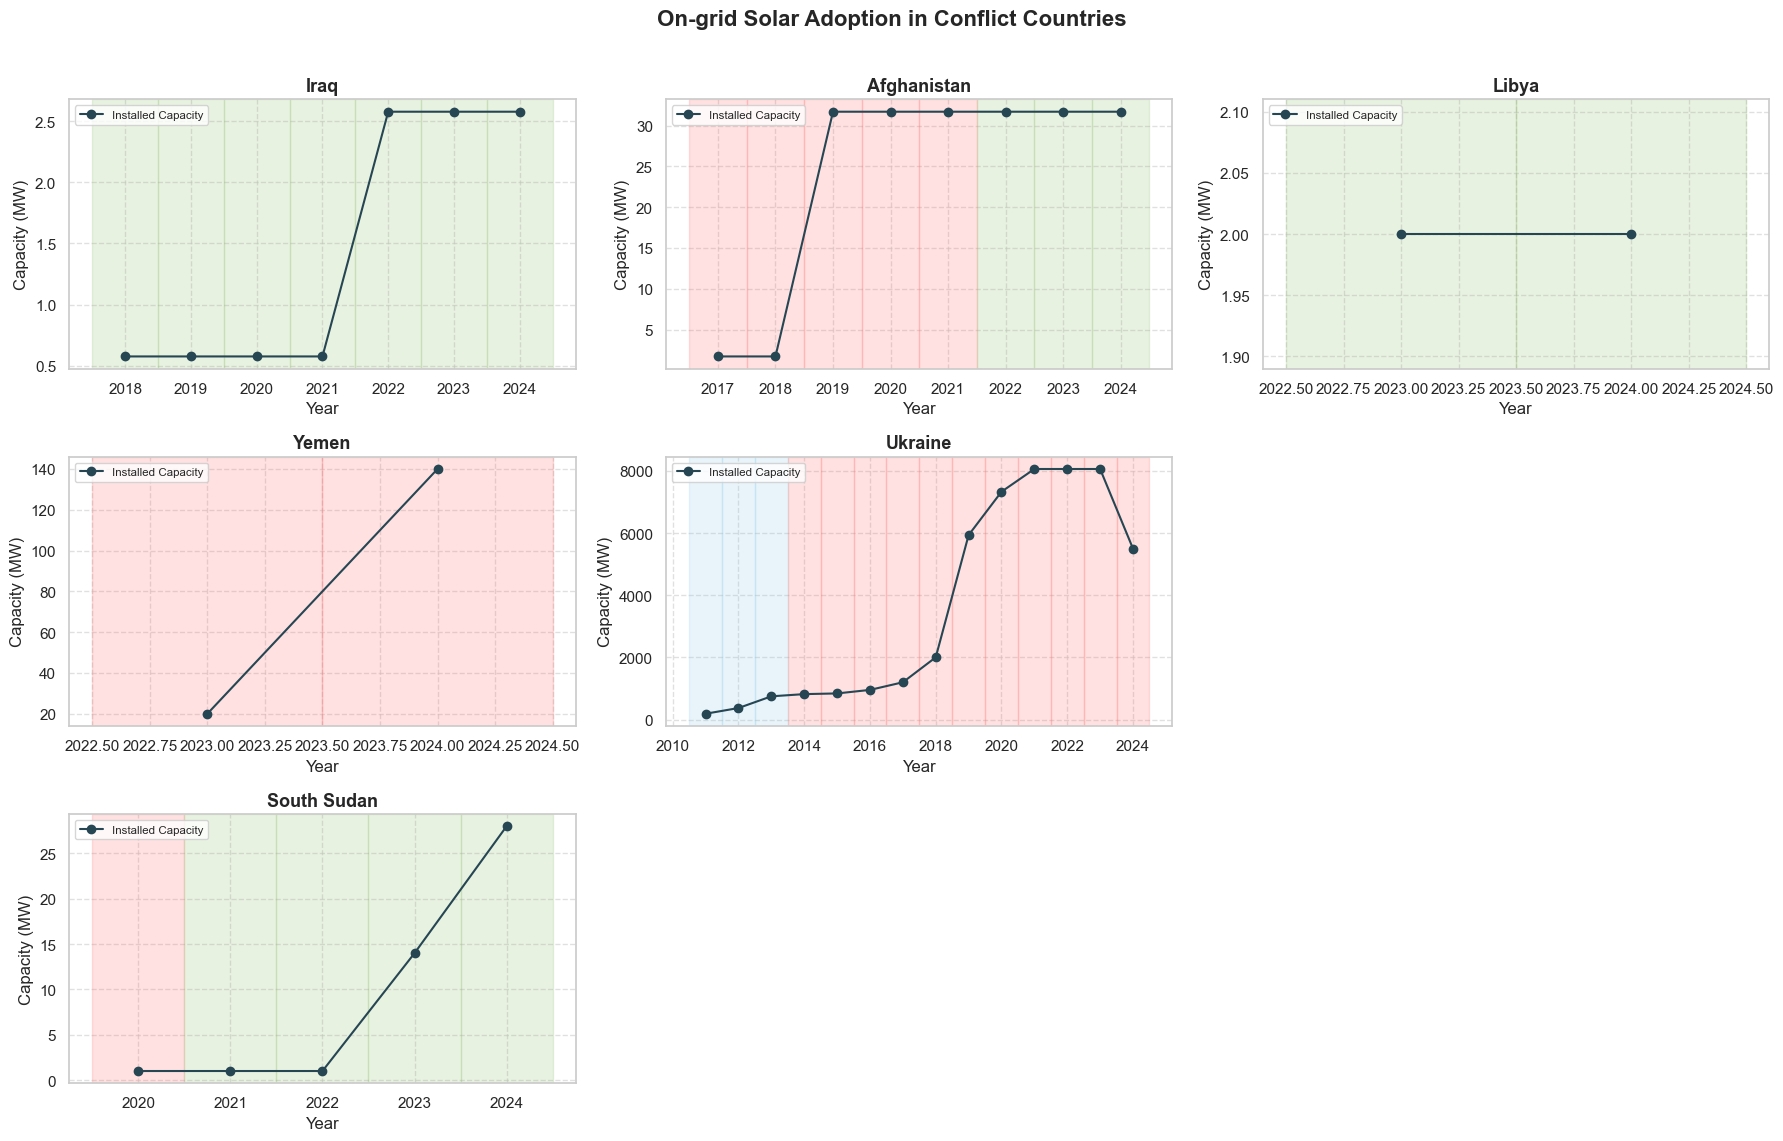

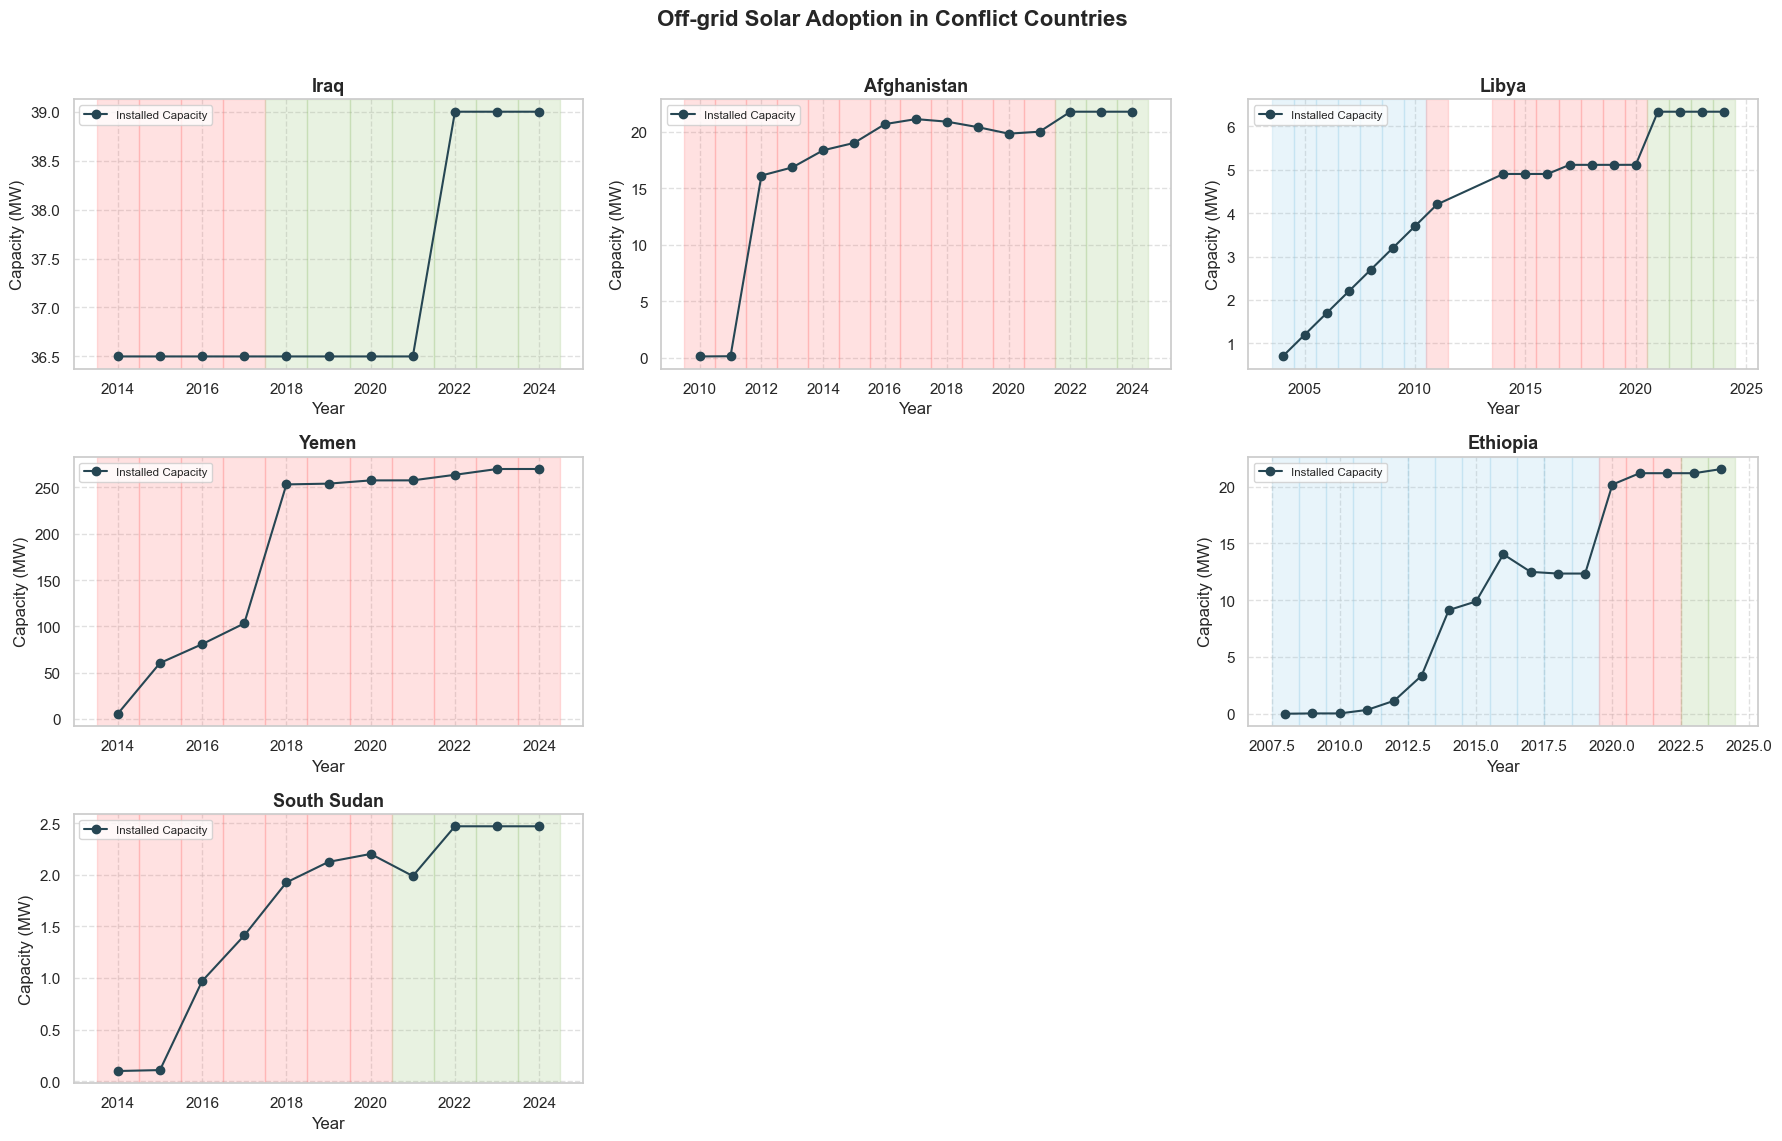

In [37]:
# 13. Average Solar Capacity by Conflict Phase and Grid Type

# Group and calculate average capacity by conflict phase and producer type
avg_by_phase_grid = (
    solar_df.groupby(["Conflict Phase", "Producer Type"])[
        "Electricity Installed Capacity (MW)"
    ]
    .mean()
    .reset_index()
)

# Define custom color palette for grid types
grid_palette = {
    "On-grid electricity": "#0077b6",  # Electric Blue
    "Off-grid electricity": "#f9a825",  # Amber/Orange
}

# Define background highlight colors for each conflict phase
bg_colors = {
    "pre-conflict": "#8ecae6",  # light blue
    "active-conflict": "#ff6b6b",  # coral red
    "post-conflict": "#90be6d",  # green
    "transitional": "#f9c74f",  # orange-yellow
}

# Unique ordered phases (optional: sort if needed)
phases = avg_by_phase_grid["Conflict Phase"].unique()

# Plot
plt.figure(figsize=(10, 6))

# Background color spans
for i, phase in enumerate(phases):
    plt.axvspan(i - 0.5, i + 0.5, color=bg_colors[phase], alpha=0.15)

# Bar plot
sns.barplot(
    data=avg_by_phase_grid,
    x="Conflict Phase",
    y="Electricity Installed Capacity (MW)",
    hue="Producer Type",
    palette=grid_palette,
    edgecolor="black",
)

# Titles and labels
plt.title("Average Solar PV Capacity by Conflict Phase and Grid Type", fontsize=14)
plt.ylabel("Avg Installed Capacity (MW)")
plt.xlabel("Conflict Phase")
plt.legend(title="Grid Type")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()
 
# Solar Energy Adoption in on-grid and off-grid systems
# Ensure Year is int
solar_df["Year"] = solar_df["Year"].astype(int)

# Define phase colors
colors = {
    "pre-conflict": "#8ecae6",  # light blue
    "active-conflict": "#ff6b6b",  # coral red
    "post-conflict": "#90be6d",  # green
    "transitional": "#f9c74f",  # orange-yellow
}

# List of countries
countries = [
    "Iraq",
    "Afghanistan",
    "Libya",
    "Yemen",
    "Ukraine",
    "Ethiopia",
    "South Sudan",
    "Sudan (the)",
    "Syrian Arab Republic (the)",
]


# Helper function to shade based on Conflict Phase column
def add_shaded_background(ax, years, phases):
    for year, phase in zip(years, phases):
        if pd.isna(phase):
            continue
        color = colors.get(phase, "#cccccc")
        ax.axvspan(year - 0.5, year + 0.5, color=color, alpha=0.2)


# Function to generate plots
def plot_conflict_solar(dataframe, producer_type_filter, title):
    filtered_df = dataframe[
        dataframe["Producer Type"].str.lower().str.contains(producer_type_filter)
    ]

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, country in enumerate(countries):
        ax = axes[i]
        country_df = filtered_df[filtered_df["Country"] == country]

        if country_df.empty:
            ax.set_visible(False)
            continue

        # Sort by year
        country_df = country_df.sort_values("Year")

        # Plot line
        ax.plot(
            country_df["Year"],
            country_df["Electricity Installed Capacity (MW)"],
            marker="o",
            color="#264653",
            label="Installed Capacity",
        )

        # Shade conflict background using Conflict Phase column
        add_shaded_background(ax, country_df["Year"], country_df["Conflict Phase"])

        ax.set_title(country, fontsize=13, fontweight="bold")
        ax.set_xlabel("Year")
        ax.set_ylabel("Capacity (MW)")
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(loc="upper left", fontsize="x-small", frameon=True)

    # Hide any unused plots
    for j in range(len(countries), len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(title, fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


# 🔹 Plot On-grid
plot_conflict_solar(solar_df, "on-grid", "On-grid Solar Adoption in Conflict Countries")

# 🔸 Plot Off-grid
plot_conflict_solar(
    solar_df, "off-grid", "Off-grid Solar Adoption in Conflict Countries"
)


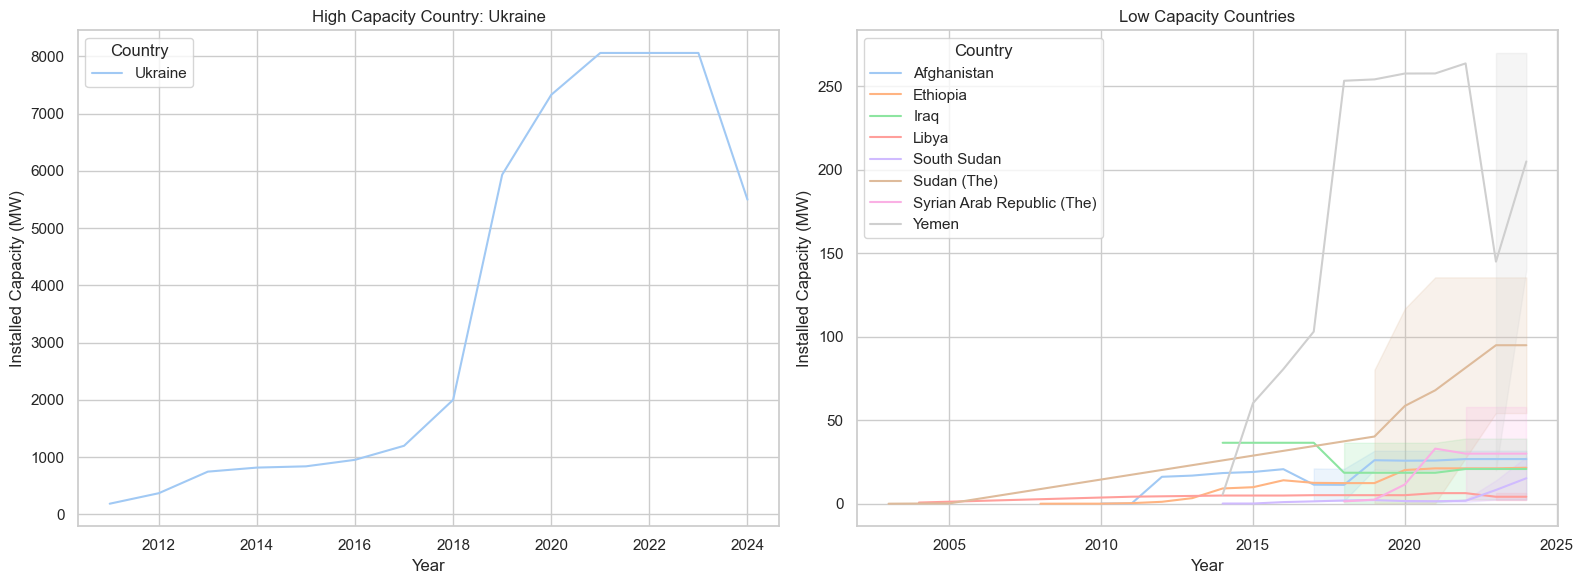

In [38]:
# 14.High vs Low Capacity
# Ukraine has much higher capacity than others, so we separate it
high_capacity_countries = ["Ukraine"]

# Getting all unique country names from our data
all_countries = solar_df["Country"].unique()

# Creating a list of countries that are NOT Ukraine (the low capacity ones)
low_capacity_countries = []
for country in all_countries:
    if country != "Ukraine":  # If it's not Ukraine
        low_capacity_countries.append(country)  # Add it to low capacity list

# Then creating two graphs side by side to see difference
fig, (left_graph, right_graph) = plt.subplots(1, 2, figsize=(16, 6))
# 1 = one row, 2 = two columns, figsize makes it wide enough for both

# The LEFT graph (for high capacity countries)
# Filter our data to only include Ukraine
ukraine_data = solar_df[solar_df["Country"] == "Ukraine"]

# Plotting Ukraine's data on the left graph
sns.lineplot(
    data=ukraine_data,
    x="Year",
    y="Electricity Installed Capacity (MW)",
    hue="Country",
    ax=left_graph,
)

# Adding labels to the left graph
left_graph.set_title("High Capacity Country: Ukraine")
left_graph.set_ylabel("Installed Capacity (MW)")
left_graph.set_xlabel("Year")

# The RIGHT graph (for low capacity countries)
# Filter our data to exclude Ukraine (keep all others)
other_countries_data = solar_df[solar_df["Country"] != "Ukraine"]

# Plotting all other countries 8 on the right graph
sns.lineplot(
    data=other_countries_data,
    x="Year",
    y="Electricity Installed Capacity (MW)",
    hue="Country",
    ax=right_graph,
)

# Add labels to the right graph
right_graph.set_title("Low Capacity Countries")
right_graph.set_ylabel("Installed Capacity (MW)")
right_graph.set_xlabel("Year")

plt.tight_layout()
plt.show()

# - Left graph: Ukraine's dramatic growth (large numbers)
# - Right graph: All other countries (smaller numbers, but now visible!)

**Key Finding:**  
 _Ukraine's solar energy_ capacity is dramatically higher than all other countries in the dataset, with over _8,000 MW_ by 2024 compared to less than _250 MW_ for any other country.   
 
 This 30-40x difference is so extreme that Ukraine must be analyzed separately from other countries (Libya, Syria, Sudan, Ethiopia, South Sudan, Afghanistan, Iraq, Yemen) to make meaningful comparisons, as Ukraine's exponential growth from 2016-2022 completely dominates the scale and obscures patterns in the remaining countries.

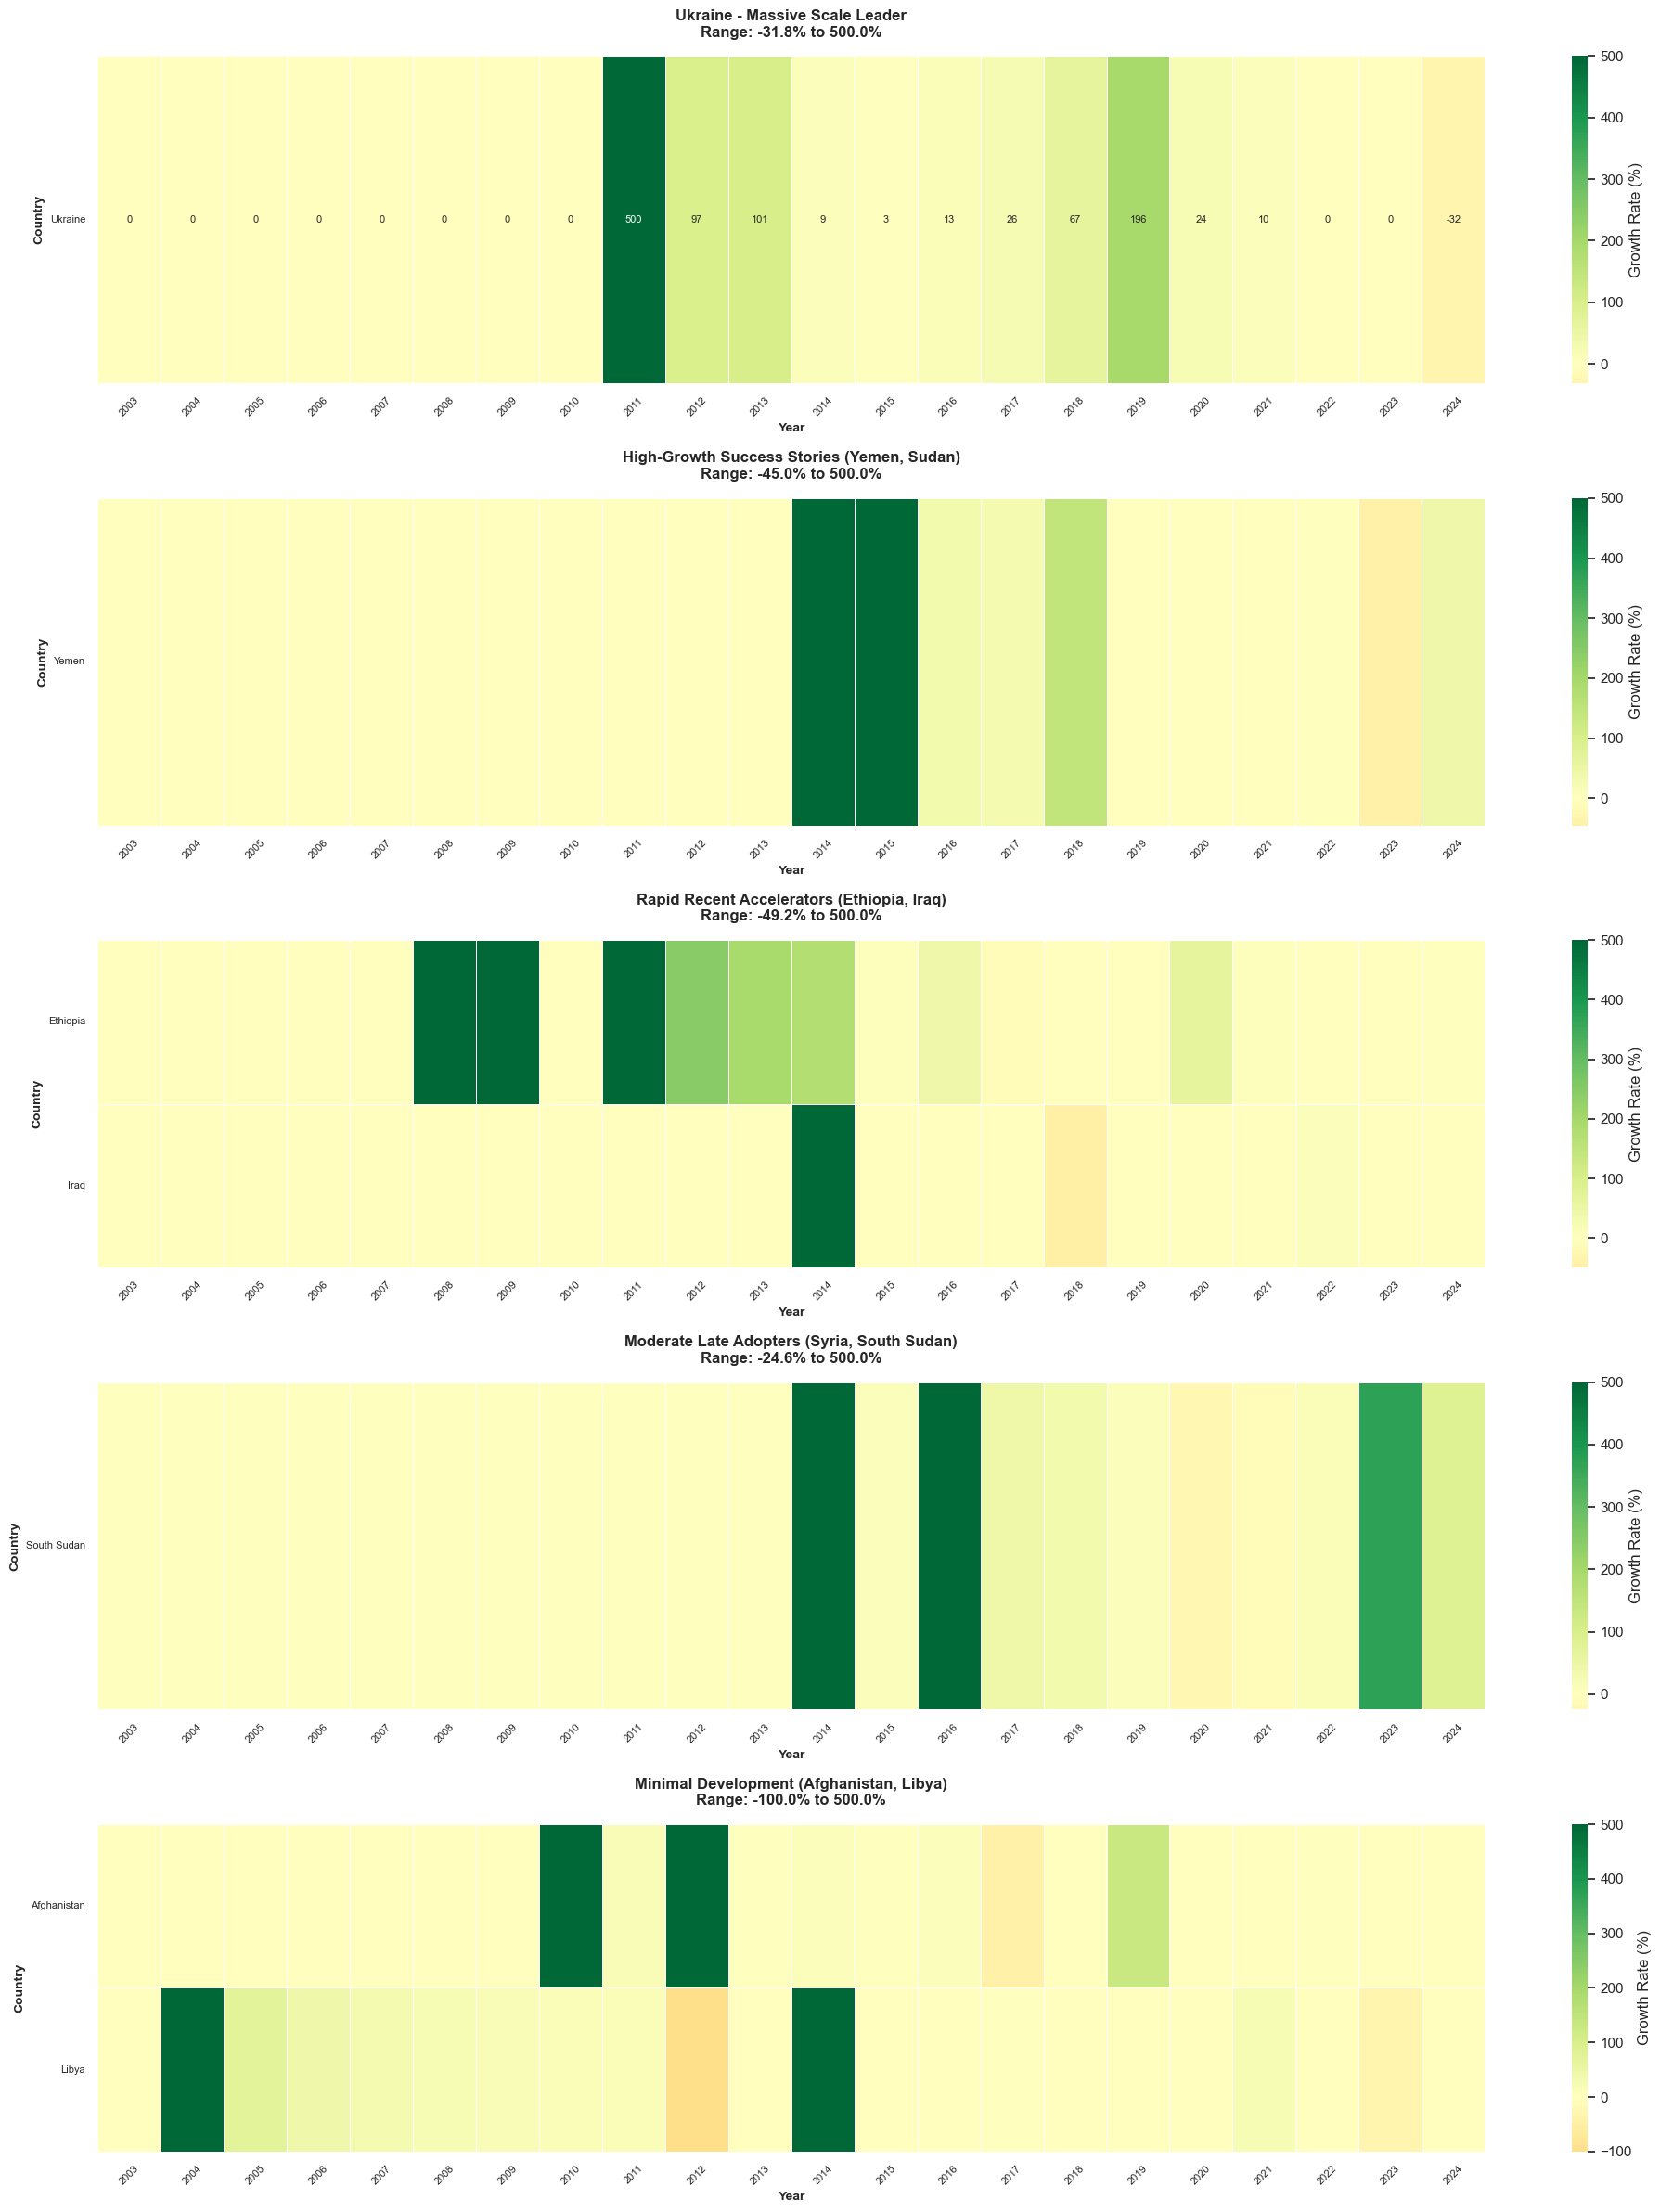

In [39]:
# 15. Heat map for countries with similar pattern
# Step 1: Prepare the data for heatmap format
heatmap_data = solar_df.pivot_table(
    index="Country",
    columns="Year",
    values="Electricity Installed Capacity (MW)",
    fill_value=0,
)


# Step 2: Calculate year-over-year growth rates
def calculate_growth_rates(data):
    growth_data = data.copy()
    growth_data.iloc[:, 0] = 0  # First year = 0% growth
    for country in growth_data.index:
        for i in range(1, len(growth_data.columns)):
            prev_year = growth_data.columns[i - 1]
            curr_year = growth_data.columns[i]
            prev_capacity = data.loc[country, prev_year]
            curr_capacity = data.loc[country, curr_year]
            if prev_capacity == 0:
                growth_data.loc[country, curr_year] = 500 if curr_capacity > 0 else 0
            else:
                growth_rate = ((curr_capacity - prev_capacity) / prev_capacity) * 100
                growth_data.loc[country, curr_year] = min(max(growth_rate, -100), 500)
    return growth_data


all_growth_data = calculate_growth_rates(heatmap_data)

# Step 3: Group countries by similar patterns
ukraine_growth = all_growth_data[all_growth_data.index == "Ukraine"]
group2_growth = all_growth_data[all_growth_data.index.isin(["Yemen", "Sudan (the)"])]
group3_growth = all_growth_data[all_growth_data.index.isin(["Ethiopia", "Iraq"])]
group4_growth = all_growth_data[
    all_growth_data.index.isin(["Syrian Arab Republic (the)", "South Sudan"])
]
group5_growth = all_growth_data[all_growth_data.index.isin(["Afghanistan", "Libya"])]

# Step 4: Plot heatmaps
fig, axes = plt.subplots(5, 1, figsize=(20, 24))

heatmap_params = {
    "cmap": "RdYlGn",
    "center": 0,
    "linewidths": 0.5,
    "linecolor": "white",
    "square": False,
    "fmt": ".0f",
}

sns.heatmap(
    ukraine_growth,
    annot=True,
    annot_kws={"fontsize": 8},
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[0],
    **heatmap_params,
)
axes[0].set_title(
    f"Ukraine - Massive Scale Leader\nRange: {ukraine_growth.min().min():.1f}% to {ukraine_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group2_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[1],
    **heatmap_params,
)
axes[1].set_title(
    f"High-Growth Success Stories (Yemen, Sudan)\nRange: {group2_growth.min().min():.1f}% to {group2_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group3_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[2],
    **heatmap_params,
)
axes[2].set_title(
    f"Rapid Recent Accelerators (Ethiopia, Iraq)\nRange: {group3_growth.min().min():.1f}% to {group3_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group4_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[3],
    **heatmap_params,
)
axes[3].set_title(
    f"Moderate Late Adopters (Syria, South Sudan)\nRange: {group4_growth.min().min():.1f}% to {group4_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group5_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[4],
    **heatmap_params,
)
axes[4].set_title(
    f"Minimal Development (Afghanistan, Libya)\nRange: {group5_growth.min().min():.1f}% to {group5_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

# Customize all axes
for ax in axes:
    ax.set_xlabel("Year", fontsize=10, fontweight="bold")
    ax.set_ylabel("Country", fontsize=10, fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.tick_params(axis="y", rotation=0, labelsize=8)

plt.tight_layout()
plt.show()

**Key Findings:**

 **When Countries Started Building Solar Power**

 **Time Periods**
1. **2009-2010**: Ukraine and Afghanistan started big projects
2. **2004-2006**: Sudan began building solar power
3. **2018-2022**: Yemen and Iraq got serious about solar
4. **2020-2025**: Syria and South Sudan joined in recently

 **How Fast They Grew**

 **Growth Speed**
- **500% growth**: Means they built A LOT very quickly (like going from 1 to 5 solar farms)
- **Steady vs. Stop-and-Go**: Ukraine and Yemen kept building consistently; others built in short bursts then stopped
- **Negative growth**: Sometimes they had less solar power than before (maybe some broke down)

 **Three Waves of Countries**

 **The Waves**
1. **Early Starters (2004–2010)**: Sudan, Ukraine, Afghanistan & Ethiopia went first  
→ _These countries had the most time to grow solar but only Ukraine sustained it._
2. **Middle Joiners (2015–2018):** Syria, South Sudan joined later  
→ _Late to start, with minimal long-term growth._  
3.**Recent Joiners (2018–2025):** Yemen, Iraq are newest  
→ _Sharp increases in short time; future potential._
1. **Barely Tried:** Libya hardly built any solar  
→ _Very low adoption overall._

 **Main Point**
All countries can grow solar power really fast when they start (500% growth), but most countries only did it for a short time and then stopped. Ukraine was the only one that kept building solar power for many years, which is why they have so much more than everyone else.